In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

# For the Ising model - you'll need to install pyGMs
# pip install pyGMs
import pyGMs as gm

In [4]:
print("Starting MovieLens Ising Model Analysis")
print("=" * 50)


Starting MovieLens Ising Model Analysis


Dataset Info:
- 100836 ratings
- 610 users
- 9724 movies
- Rating scale: 0.5 to 5.0


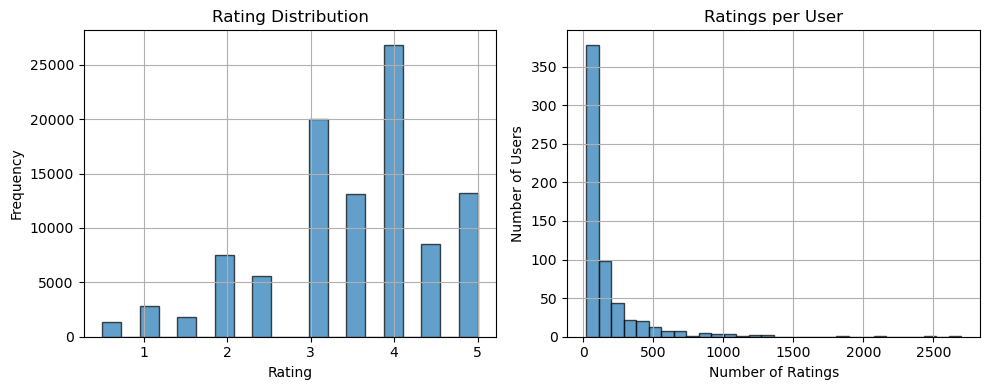


Rating Statistics:
count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


In [5]:
## 1. DATA LOADING AND EXPLORATION

# Load the MovieLens data
ratings_df = pd.read_csv('../data/ml-latest-small/ratings.csv')
movies_df = pd.read_csv('../data/ml-latest-small/movies.csv')

print(f"Dataset Info:")
print(f"- {len(ratings_df)} ratings")
print(f"- {ratings_df['userId'].nunique()} users") 
print(f"- {ratings_df['movieId'].nunique()} movies")
print(f"- Rating scale: {ratings_df['rating'].min()} to {ratings_df['rating'].max()}")

# Look at rating distribution
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
ratings_df['rating'].hist(bins=20, edgecolor='black', alpha=0.7)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
ratings_per_user = ratings_df.groupby('userId').size()
ratings_per_user.hist(bins=30, edgecolor='black', alpha=0.7)
plt.title('Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.tight_layout()
plt.show()

print(f"\nRating Statistics:")
print(ratings_df['rating'].describe())

In [6]:
## 2. CREATE USER-MOVIE MATRIX (like in RecSys Ising example)

# For computational efficiency, let's start with a subset
# Take users with at least 50 ratings and movies with at least 20 ratings
user_counts = ratings_df.groupby('userId').size()
movie_counts = ratings_df.groupby('movieId').size()

active_users = user_counts[user_counts >= 50].index
popular_movies = movie_counts[movie_counts >= 20].index

print(f"\nFiltering for computational efficiency:")
print(f"- Users with ≥50 ratings: {len(active_users)}")
print(f"- Movies with ≥20 ratings: {len(popular_movies)}")

# Filter the data
filtered_ratings = ratings_df[
    (ratings_df['userId'].isin(active_users)) & 
    (ratings_df['movieId'].isin(popular_movies))
]

print(f"- Filtered dataset: {len(filtered_ratings)} ratings")

# Create user-movie matrix
def create_rating_matrix(ratings_df, fill_value=-1):
    """Create user-movie rating matrix"""
    # Create a pivot table
    user_movie_matrix = ratings_df.pivot_table(
        index='userId', 
        columns='movieId', 
        values='rating',
        fill_value=fill_value
    )
    return user_movie_matrix

rating_matrix = create_rating_matrix(filtered_ratings, fill_value=0)
print(f"\nRating matrix shape: {rating_matrix.shape}")
print(f"Sparsity: {(rating_matrix == 0).sum().sum() / (rating_matrix.shape[0] * rating_matrix.shape[1]):.3f}")



Filtering for computational efficiency:
- Users with ≥50 ratings: 385
- Movies with ≥20 ratings: 1297
- Filtered dataset: 62001 ratings

Rating matrix shape: (385, 1297)
Sparsity: 0.876


In [7]:
## 3. BINARY TRANSFORMATION (like in RecSys Ising example)

# Convert to binary: 1 = "liked" (rating >= 4), 0 = "not liked" (rating < 4)
# Note: RecSys example used threshold of 7/10, we'll use 4/5
def binarize_ratings(rating_matrix, threshold=4.0):
    """Convert ratings to binary (liked/not liked)"""
    binary_matrix = (rating_matrix >= threshold).astype(int)
    # Set unrated items to -1 so we can distinguish from "disliked"
    binary_matrix[rating_matrix == 0] = -1
    return binary_matrix

binary_matrix = binarize_ratings(rating_matrix, threshold=4.0)
print(f"\nBinary matrix statistics:")
print(f"- Liked (1): {(binary_matrix == 1).sum().sum()}")
print(f"- Disliked (0): {(binary_matrix == 0).sum().sum()}")
print(f"- Unrated (-1): {(binary_matrix == -1).sum().sum()}")

# For Ising model, we need only rated items (remove -1s)
# We'll create training data where each row is a user, each column is a movie
# Only include movies that have enough ratings

def prepare_ising_data(binary_matrix, min_ratings_per_movie=10):
    """Prepare data for Ising model training"""
    # Count non-missing ratings per movie
    rated_counts = (binary_matrix != -1).sum(axis=0)
    valid_movies = rated_counts[rated_counts >= min_ratings_per_movie].index
    
    # Filter to valid movies
    ising_data = binary_matrix[valid_movies].T  # Transpose: rows=users, cols=movies
    
    # For each user, only keep movies they've rated
    clean_data = []
    user_ids = []
    
    for user_id in ising_data.index:
        user_ratings = ising_data.loc[user_id]
        rated_movies = user_ratings[user_ratings != -1]
        
        if len(rated_movies) >= 5:  # User must have rated at least 5 valid movies
            clean_data.append(rated_movies.values)
            user_ids.append(user_id)
    
    # Convert to matrix (this will be ragged, so we need to handle it carefully)
    return clean_data, user_ids, valid_movies

clean_data, user_ids, valid_movies = prepare_ising_data(binary_matrix)
print(f"\nIssing model data preparation:")
print(f"- Valid movies: {len(valid_movies)}")
print(f"- Valid users: {len(user_ids)}")

# Get movie names for the valid movies
valid_movie_names = movies_df[movies_df['movieId'].isin(valid_movies)][['movieId', 'title']]
print(f"\nExample movies in our analysis:")
print(valid_movie_names.head(10))


Binary matrix statistics:
- Liked (1): 32453
- Disliked (0): 29548
- Unrated (-1): 437344

Issing model data preparation:
- Valid movies: 1297
- Valid users: 1297

Example movies in our analysis:
    movieId                               title
0         1                    Toy Story (1995)
1         2                      Jumanji (1995)
2         3             Grumpier Old Men (1995)
4         5  Father of the Bride Part II (1995)
5         6                         Heat (1995)
6         7                      Sabrina (1995)
9        10                    GoldenEye (1995)
10       11      American President, The (1995)
15       16                       Casino (1995)
16       17        Sense and Sensibility (1995)


In [9]:
movie_popularity = (binary_matrix != -1).sum(axis=0).sort_values(ascending=False)
N_MOVIES = 50
N_USERS = 100

# Get top movies by number of ratings
top_movies_list = movie_popularity.head(N_MOVIES).index.tolist()

# Get users who have rated enough of these top movies
users_with_enough_ratings = []
for user_id in binary_matrix.index:
    user_ratings = binary_matrix.loc[user_id, top_movies_list]
    num_rated = (user_ratings != -1).sum()
    if num_rated >= 10:  # User must have rated at least 10 of the top movies
        users_with_enough_ratings.append(user_id)

# Take first N_USERS
selected_users = users_with_enough_ratings[:N_USERS]
print(f"Selected {len(selected_users)} users and {len(top_movies_list)} movies")

# Create final training matrix
X_ising = np.zeros((len(selected_users), N_MOVIES))
for i, user_id in enumerate(selected_users):
    user_data = binary_matrix.loc[user_id, top_movies_list]
    
    # Calculate user's overall preference for imputation
    rated_mask = (user_data != -1)
    if rated_mask.sum() > 0:
        user_pref = (user_data[rated_mask] == 1).mean()
    else:
        user_pref = 0.5
    
    for j, movie_id in enumerate(top_movies_list):
        if user_data[movie_id] != -1:
            # Use actual rating
            X_ising[i, j] = user_data[movie_id]
        else:
            # Impute missing values based on user preference
            X_ising[i, j] = 1 if np.random.random() < user_pref else 0

print(f"\nFinal Ising training matrix: {X_ising.shape}")
print(f"Fraction of 'likes': {X_ising.mean():.3f}")

# Get movie titles for display
movie_titles = []
for movie_id in top_movies_list:
    title = movies_df[movies_df['movieId'] == movie_id]['title'].iloc[0]
    # Shorten title for display
    short_title = title[:20] + "..." if len(title) > 20 else title
    movie_titles.append(short_title)

print(f"\nMovies in our analysis:")
for i, title in enumerate(movie_titles[:10]):
    print(f"{i}: {title}")

Selected 100 users and 50 movies

Final Ising training matrix: (100, 50)
Fraction of 'likes': 0.653

Movies in our analysis:
0: Forrest Gump (1994)
1: Pulp Fiction (1994)
2: Shawshank Redemption...
3: Matrix, The (1999)
4: Silence of the Lambs...
5: Star Wars: Episode I...
6: Jurassic Park (1993)
7: Star Wars: Episode V...
8: Braveheart (1995)
9: Fight Club (1999)


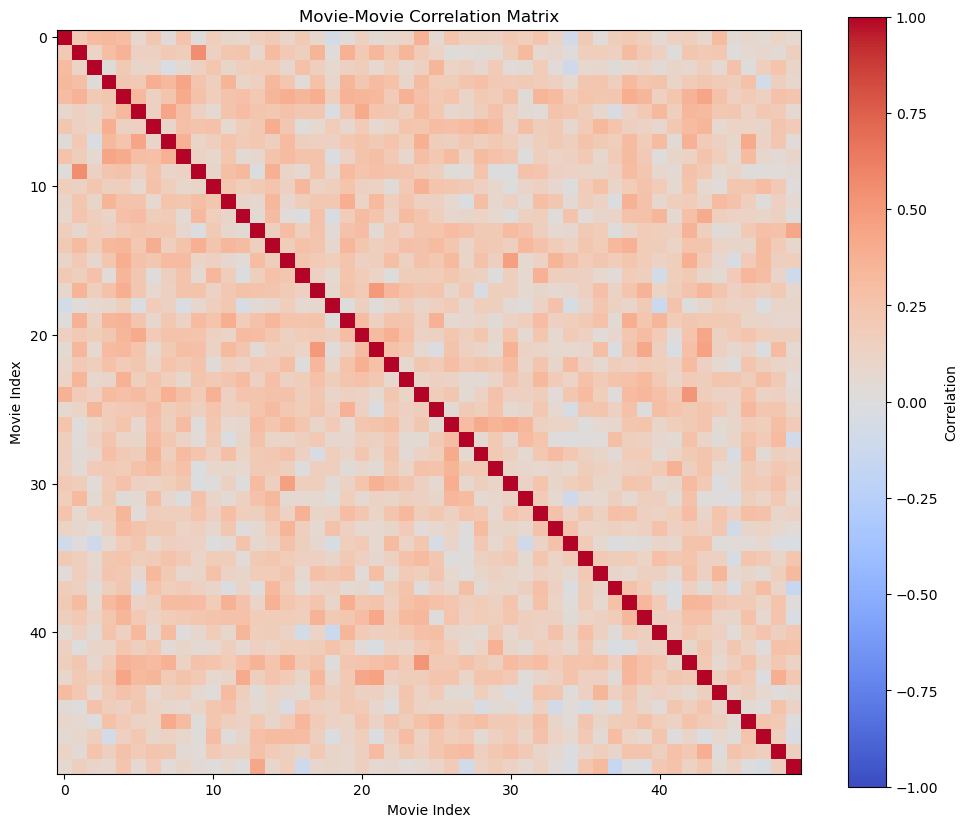


Most correlated movie pairs:
Forrest Gump (1994) ↔ Shawshank Redemption...: 0.310
Forrest Gump (1994) ↔ Matrix, The (1999): 0.323
Forrest Gump (1994) ↔ Back to the Future (...: 0.372
Forrest Gump (1994) ↔ Mrs. Doubtfire (1993...: 0.304
Pulp Fiction (1994) ↔ Silence of the Lambs...: 0.356
Pulp Fiction (1994) ↔ Fight Club (1999): 0.554
Pulp Fiction (1994) ↔ Seven (a.k.a. Se7en)...: 0.301
Pulp Fiction (1994) ↔ Usual Suspects, The ...: 0.351
Pulp Fiction (1994) ↔ Godfather, The (1972...: 0.365
Pulp Fiction (1994) ↔ Sixth Sense, The (19...: 0.332
Pulp Fiction (1994) ↔ Fargo (1996): 0.338
Pulp Fiction (1994) ↔ Lion King, The (1994...: 0.316
Pulp Fiction (1994) ↔ Twelve Monkeys (a.k....: 0.301
Shawshank Redemption... ↔ Apollo 13 (1995): 0.342
Matrix, The (1999) ↔ Jurassic Park (1993): 0.386
Matrix, The (1999) ↔ Star Wars: Episode V...: 0.327
Matrix, The (1999) ↔ Braveheart (1995): 0.436
Matrix, The (1999) ↔ American Beauty (199...: 0.347
Matrix, The (1999) ↔ Seven (a.k.a. Se7en)...: 0.321
Ma

In [11]:
## 5. BASIC ANALYSIS

# Correlation between movies
movie_corrs = np.corrcoef(X_ising.T)
plt.figure(figsize=(12, 10))
plt.imshow(movie_corrs, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')
plt.title('Movie-Movie Correlation Matrix')
plt.xlabel('Movie Index')
plt.ylabel('Movie Index')
plt.show()

# Most correlated movie pairs
print(f"\nMost correlated movie pairs:")
for i in range(len(top_movies_list)):
    for j in range(i+1, len(top_movies_list)):
        corr = movie_corrs[i, j]
        if corr > 0.3:  # Show strong positive correlations
            print(f"{movie_titles[i]} ↔ {movie_titles[j]}: {corr:.3f}")

print(f"\nData preparation complete!")


In [14]:
# PART 2: ISING MODEL IMPLEMENTATION
print("\n" + "="*60)
print("ISING MODEL IMPLEMENTATION")
print("="*60)

def array_to_dict(x_array):
    """Convert numpy array to dictionary format for pyGMs"""
    return {i: int(x_array[i]) for i in range(len(x_array))}

X_ising_dict = [array_to_dict(x) for x in X_ising]

# Initialize baseline for comparison
train_ll_indep = None

def compute_pseudolikelihood(X, nbrs, th_ij, th_i):
    """Compute pseudo-likelihood of the data"""
    total_ll = 0
    n_samples, n_vars = X.shape
    
    for i in range(n_vars):  # For each variable
        for j in range(n_samples):  # For each sample
            # Compute P(Xi | X_neighbors)
            linear_term = th_i[i]  # Bias term
            
            # Add contributions from neighbors
            for k, neighbor in enumerate(nbrs[i]):
                linear_term += th_ij[i][k] * X[j, neighbor]
            
            # Logistic function: P(Xi=1 | neighbors) = sigmoid(linear_term)
            prob_1 = 1 / (1 + np.exp(-2 * linear_term))
            
            # Add log probability
            if X[j, i] == 1:
                total_ll += np.log(prob_1 + 1e-10)
            else:
                total_ll += np.log(1 - prob_1 + 1e-10)
    
    return total_ll / (n_samples * n_vars)


ISING MODEL IMPLEMENTATION


In [15]:
## STEP 1: INDEPENDENT BASELINE MODEL (from RecSys example)

print("\n1. INDEPENDENT BASELINE MODEL")
print("-" * 40)

# Calculate empirical probability of liking each movie independently
pXi = np.mean(X_ising, axis=0)  # P(like movie i)

print(f"Movie preferences (top 10 most liked):")
sorted_prefs = [(i, movie_titles[i], pXi[i]) for i in range(len(pXi))]
sorted_prefs.sort(key=lambda x: x[2], reverse=True)

for i, (idx, title, prob) in enumerate(sorted_prefs[:10]):
    print(f"{i+1:2d}. {title:25s}: {prob:.3f}")

try:
    import pyGMs as gm
    
    # Independent model: each movie has independent probability
    model0_factors = []
    for i in range(len(pXi)):
        # Factor for movie i: [P(dislike), P(like)]
        factor = gm.Factor([gm.Var(i, 2)], [1-pXi[i], pXi[i]])
        model0_factors.append(factor)
    
    model0 = gm.GraphModel(model0_factors)
    
    # Evaluate log-likelihood on training data
    train_ll_indep = np.mean([model0.logValue(x) for x in X_ising_dict])
    print(f"\nIndependent model Train LL: {train_ll_indep:.4f}")
    
    pyGMs_available = True
    
except ImportError:
    print("\npyGMs not available - computing log-likelihood manually")
    
    # Manual log-likelihood calculation
    def independent_log_likelihood(X, pXi):
        ll = 0
        for x in X:
            for i, rating in enumerate(x):
                if rating == 1:
                    ll += np.log(pXi[i] + 1e-10)  # Add small epsilon
                else:
                    ll += np.log(1 - pXi[i] + 1e-10)
        return ll / len(X)
    
    train_ll_indep = independent_log_likelihood(X_ising, pXi)
    print(f"Independent model Train LL: {train_ll_indep:.4f}")
    
    pyGMs_available = False



1. INDEPENDENT BASELINE MODEL
----------------------------------------
Movie preferences (top 10 most liked):
 1. Shawshank Redemption...  : 0.770
 2. American Beauty (199...  : 0.770
 3. Star Wars: Episode V...  : 0.760
 4. Terminator 2: Judgme...  : 0.750
 5. Forrest Gump (1994)      : 0.730
 6. Silence of the Lambs...  : 0.730
 7. Matrix, The (1999)       : 0.720
 8. Fargo (1996)             : 0.720
 9. Memento (2000)           : 0.720
10. Pulp Fiction (1994)      : 0.710

Independent model Train LL: -31.6544


In [16]:
## STEP 2: ISING MODEL STRUCTURE LEARNING
## Using L1-regularized logistic regression (from RecSys example)

print("\n\n2. ISING MODEL STRUCTURE LEARNING")
print("-" * 40)

from sklearn.linear_model import LogisticRegression

# Parameters for structure learning
C_values = [0.1, 0.5, 1.0, 2.0, 5.0]  # Different regularization strengths
results = {}

for C in C_values:
    print(f"\nLearning structure with C={C}...")
    
    # For each movie Xi, learn its neighborhood using L1-regularized logistic regression
    nbrs, th_ij, th_i = [None]*len(movie_titles), [None]*len(movie_titles), np.zeros(len(movie_titles))
    
    X_tmp = X_ising.copy()
    
    for i in range(len(movie_titles)):
        # Remove movie i from features (can't predict itself)
        X_features = np.delete(X_tmp, i, axis=1)
        y_target = X_tmp[:, i]  # Predict movie i
        
        # Fit L1-regularized logistic regression
        lr = LogisticRegression(penalty='l1', C=C, solver='liblinear', random_state=42)
        lr.fit(X_features, y_target)
        
        # Find non-zero coefficients (neighbors)
        coef_with_i = np.insert(lr.coef_[0], i, 0)  # Insert 0 for self-connection
        nbrs[i] = np.where(np.abs(coef_with_i) > 1e-6)[0]
        nbrs[i] = nbrs[i][nbrs[i] != i]  # Remove self-connection
        
        # Store parameters (divide by 2 for Ising parameterization)
        th_ij[i] = coef_with_i[nbrs[i]] / 2.0
        th_i[i] = lr.intercept_[0] / 2.0
    
    # Calculate average connectivity
    avg_connectivity = np.mean([len(nn) for nn in nbrs])
    
    results[C] = {
        'nbrs': nbrs,
        'th_ij': th_ij, 
        'th_i': th_i,
        'avg_connectivity': avg_connectivity
    }
    
    print(f"Average connectivity: {avg_connectivity:.2f} ± {np.std([len(nn) for nn in nbrs]):.2f}")




2. ISING MODEL STRUCTURE LEARNING
----------------------------------------

Learning structure with C=0.1...
Average connectivity: 2.92 ± 1.62

Learning structure with C=0.5...
Average connectivity: 12.88 ± 2.33

Learning structure with C=1.0...
Average connectivity: 24.10 ± 2.74

Learning structure with C=2.0...
Average connectivity: 33.02 ± 2.64

Learning structure with C=5.0...
Average connectivity: 40.18 ± 2.24


In [17]:
## STEP 3: BUILD ISING MODELS AND EVALUATE

print("\n\n3. MODEL EVALUATION")
print("-" * 40)

def build_ising_model(nbrs, th_ij, th_i, n_movies):
    """Build Ising model from learned parameters"""
    if not pyGMs_available:
        return None
        
    factors = []
    
    # Single-variable factors (bias terms)
    for i in range(n_movies):
        t = th_i[i]
        factor = gm.Factor([gm.Var(i, 2)], [-t, t]).exp()
        factors.append(factor)
    
    # Pairwise factors
    added_edges = set()
    for i in range(n_movies):
        for j_idx, j in enumerate(nbrs[i]):
            if j < i and (j, i) not in added_edges:  # Avoid duplicate edges
                t = th_ij[i][j_idx]
                scope = [gm.Var(i, 2), gm.Var(int(j), 2)]
                factor = gm.Factor(scope, [[t, -t], [-t, t]]).exp()
                factors.append(factor)
                added_edges.add((i, j))
    
    model = gm.GraphModel(factors)
    model.makeMinimal()
    return model

# Evaluate models with different regularization
best_C = None
best_model = None
best_pseudo_ll = -np.inf

for C in C_values:
    print(f"\nEvaluating model with C={C}:")
    
    nbrs = results[C]['nbrs']
    th_ij = results[C]['th_ij']
    th_i = results[C]['th_i']
    
    if pyGMs_available:
        # Try to build the model
        try:
            model = build_ising_model(nbrs, th_ij, th_i, len(movie_titles))
            
            # Check if we can compute exact likelihood
            order, _ = gm.eliminationOrder(model, 'minfill')
            pt = gm.PseudoTree(model, order)
            
            print(f"  Graph structure: {len(model.factors)-len(movie_titles)} edges")
            print(f"  Tree width: {pt.width}")
            
            if pt.width <= 20:  # If tree width is manageable
                import pyGMs.wmb
                jt = gm.wmb.JTree(model, elimOrder=order)
                lnZ = jt.msgForward()
                
                train_ll = np.mean([model.logValue(x) for x in X_ising_dict]) - lnZ
                print(f"  Exact Train LL: {train_ll:.4f}")
                
                if train_ll > best_pseudo_ll:
                    best_pseudo_ll = train_ll
                    best_C = C
                    best_model = model
            else:
                print(f"  Tree width too high for exact inference")
                
        except Exception as e:
            print(f"  Could not build model: {e}")
    
    # Always compute pseudo-likelihood as backup
    pseudo_ll = compute_pseudolikelihood(X_ising, nbrs, th_ij, th_i)
    print(f"  Pseudo-likelihood: {pseudo_ll:.4f}")
    
    if pseudo_ll > best_pseudo_ll:
        best_pseudo_ll = pseudo_ll
        best_C = C

print(f"\n\nBEST MODEL: C={best_C}")
print(f"Best pseudo-likelihood: {best_pseudo_ll:.4f}")
print(f"Improvement over independent: {best_pseudo_ll - train_ll_indep:.4f}")




3. MODEL EVALUATION
----------------------------------------

Evaluating model with C=0.1:
  Graph structure: 30 edges
  Tree width: 8
  Exact Train LL: -31.5063
  Pseudo-likelihood: -0.5934

Evaluating model with C=0.5:
  Graph structure: 271 edges
  Tree width: 29
  Tree width too high for exact inference
  Pseudo-likelihood: -0.4652

Evaluating model with C=1.0:
  Graph structure: 567 edges
  Tree width: 39
  Tree width too high for exact inference
  Pseudo-likelihood: -0.3599

Evaluating model with C=2.0:
  Graph structure: 783 edges
  Tree width: 42
  Tree width too high for exact inference
  Pseudo-likelihood: -0.2762

Evaluating model with C=5.0:
  Graph structure: 961 edges
  Tree width: 45
  Tree width too high for exact inference
  Pseudo-likelihood: -0.1880


BEST MODEL: C=5.0
Best pseudo-likelihood: -0.1880
Improvement over independent: 31.4664


In [18]:
## STEP 4: ANALYZE LEARNED STRUCTURE

print("\n\n4. STRUCTURE ANALYSIS")
print("-" * 40)

best_nbrs = results[best_C]['nbrs']
best_th_ij = results[best_C]['th_ij']

# Show strongest connections
print(f"\nStrongest learned dependencies (C={best_C}):")
connections = []
for i in range(len(movie_titles)):
    for j_idx, j in enumerate(best_nbrs[i]):
        if j > i:  # Avoid duplicates
            weight = abs(best_th_ij[i][j_idx])
            connections.append((weight, i, j, best_th_ij[i][j_idx]))

connections.sort(reverse=True)
for weight, i, j, orig_weight in connections[:15]:
    sign = "+" if orig_weight > 0 else "-"
    print(f"{movie_titles[i]:25s} {sign} {movie_titles[j]:25s}: {weight:.3f}")




4. STRUCTURE ANALYSIS
----------------------------------------

Strongest learned dependencies (C=5.0):
Star Wars: Episode V...   + Star Wars: Episode I...  : 2.871
Forrest Gump (1994)       + Back to the Future (...  : 2.734
Sixth Sense, The (19...   + Alien (1979)             : 2.639
Pulp Fiction (1994)       - Aladdin (1992)           : 2.502
Lord of the Rings: T...   + Lion King, The (1994...  : 2.340
Saving Private Ryan ...   - Back to the Future (...  : 2.330
Jurassic Park (1993)      - Godfather, The (1972...  : 2.252
Pulp Fiction (1994)       + Fight Club (1999)        : 2.194
Usual Suspects, The ...   + Sixth Sense, The (19...  : 2.160
Star Wars: Episode I...   - Princess Bride, The ...  : 2.137
Back to the Future (...   + Pirates of the Carib...  : 2.116
Lord of the Rings: T...   + Fugitive, The (1993)     : 2.098
Schindler's List (19...   + Aladdin (1992)           : 2.068
American Beauty (199...   + Sixth Sense, The (19...  : 2.064
Raiders of the Lost ...   + Ace Ventura:



5. GRAPH VISUALIZATION
----------------------------------------
Graph has 50 nodes and 878 edges


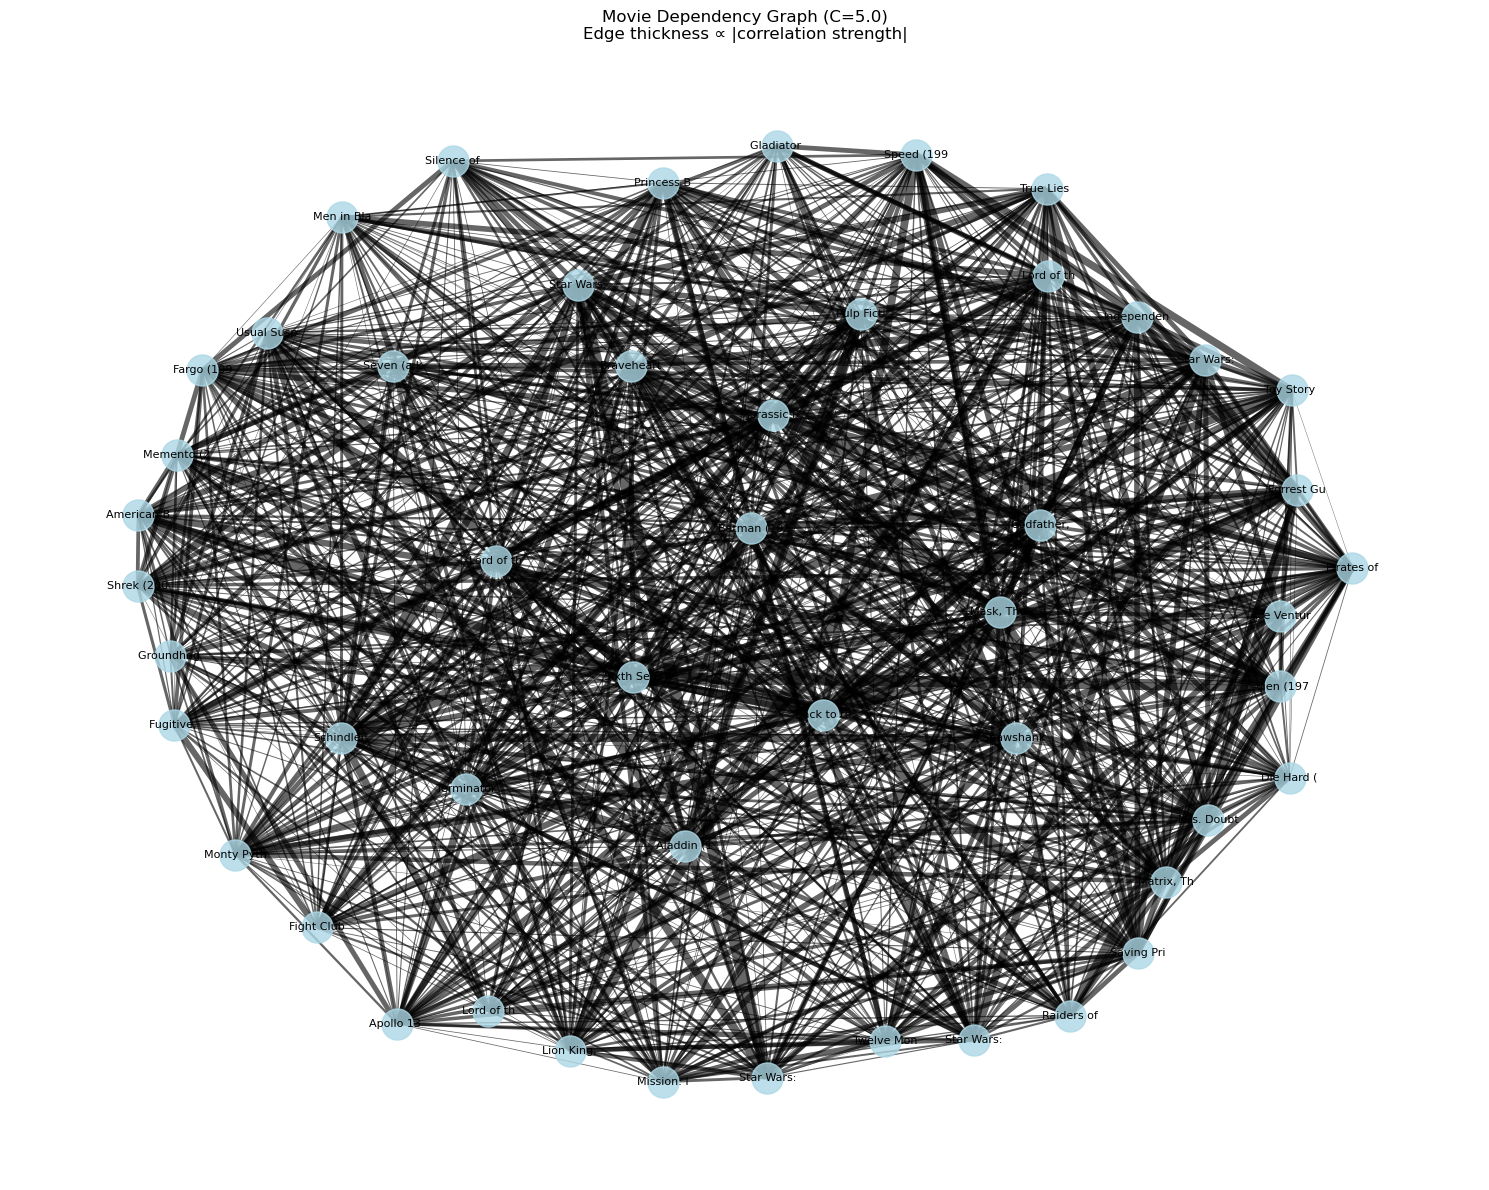


Analysis complete!
Key findings:
- Best regularization: C=5.0
- Average connectivity: 40.2 movies per movie
- Strongest connection: 2.871
- Improvement over independent model: 31.4664


In [19]:
## STEP 5: VISUALIZATION

print("\n\n5. GRAPH VISUALIZATION")
print("-" * 40)

import networkx as nx

# Create graph
G = nx.Graph()

# Add nodes
for i, title in enumerate(movie_titles):
    G.add_node(i, title=title)

# Add edges from learned structure
for i in range(len(movie_titles)):
    for j_idx, j in enumerate(best_nbrs[i]):
        if j > i:  # Avoid duplicate edges
            weight = abs(best_th_ij[i][j_idx])
            if weight > 0.1:  # Only show strong connections
                G.add_edge(i, j, weight=weight)

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

# Plot the graph
plt.figure(figsize=(15, 12))
pos = nx.spring_layout(G, k=3, iterations=50)

# Draw edges with thickness proportional to weight
edges = G.edges(data=True)
weights = [edge[2]['weight'] for edge in edges]
nx.draw_networkx_edges(G, pos, width=[w*3 for w in weights], alpha=0.6)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                      node_size=500, alpha=0.8)

# Add labels
labels = {i: title[:10] for i, title in enumerate(movie_titles)}
nx.draw_networkx_labels(G, pos, labels, font_size=8)

plt.title(f"Movie Dependency Graph (C={best_C})\nEdge thickness ∝ |correlation strength|")
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"\nAnalysis complete!")
print(f"Key findings:")
print(f"- Best regularization: C={best_C}")
print(f"- Average connectivity: {results[best_C]['avg_connectivity']:.1f} movies per movie")
print(f"- Strongest connection: {connections[0][0]:.3f}")
print(f"- Improvement over independent model: {best_pseudo_ll - train_ll_indep:.4f}")

In [20]:
# PART 3: PREDICTION EVALUATION
# Test how well the Ising model predicts missing ratings

print("\n" + "="*60)
print("PREDICTION EVALUATION")
print("="*60)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



PREDICTION EVALUATION


In [21]:
## STEP 1: CREATE TRAIN/TEST SPLIT

def create_missing_data_test(X, test_ratio=0.2, random_state=42):
    """Create test set by hiding some ratings"""
    np.random.seed(random_state)
    
    X_train = X.copy()
    X_test = X.copy()
    
    n_users, n_movies = X.shape
    n_test = int(n_users * n_movies * test_ratio)
    
    # Randomly select positions to hide
    test_positions = []
    for _ in range(n_test):
        user_idx = np.random.randint(n_users)
        movie_idx = np.random.randint(n_movies)
        test_positions.append((user_idx, movie_idx))
    
    # Hide ratings in training set
    for user_idx, movie_idx in test_positions:
        X_train[user_idx, movie_idx] = -1  # Mark as missing
    
    return X_train, X_test, test_positions

X_train, X_test_true, test_positions = create_missing_data_test(X_ising, test_ratio=0.15)
print(f"Created test set with {len(test_positions)} hidden ratings")

Created test set with 750 hidden ratings


In [22]:
## STEP 2: PREDICTION METHODS

def predict_independent(X_train, test_positions, pXi):
    """Predict using independent model (baseline)"""
    predictions = []
    
    for user_idx, movie_idx in test_positions:
        # Use movie's overall popularity
        prob_like = pXi[movie_idx]
        pred = 1 if prob_like > 0.5 else 0
        predictions.append(pred)
    
    return np.array(predictions)

def predict_ising_simple(X_train, test_positions, nbrs, th_ij, th_i):
    """Predict using learned Ising model structure"""
    predictions = []
    
    for user_idx, movie_idx in test_positions:
        # Use the conditional probability P(movie_idx | neighbors)
        user_ratings = X_train[user_idx]
        
        # Compute linear term for this movie
        linear_term = th_i[movie_idx]  # Bias
        
        # Add neighbor contributions
        neighbor_indices = nbrs[movie_idx]
        for k, neighbor_idx in enumerate(neighbor_indices):
            if user_ratings[neighbor_idx] != -1:  # If neighbor is rated
                linear_term += th_ij[movie_idx][k] * user_ratings[neighbor_idx]
        
        # Convert to probability using logistic function
        prob_like = 1 / (1 + np.exp(-2 * linear_term))
        pred = 1 if prob_like > 0.5 else 0
        predictions.append(pred)
    
    return np.array(predictions)

def predict_user_average(X_train, test_positions):
    """Predict using user's average rating (collaborative filtering baseline)"""
    predictions = []
    
    for user_idx, movie_idx in test_positions:
        user_ratings = X_train[user_idx]
        rated_mask = (user_ratings != -1)
        
        if rated_mask.sum() > 0:
            user_avg = user_ratings[rated_mask].mean()
            pred = 1 if user_avg > 0.5 else 0
        else:
            pred = 1  # Default to "like" if no other ratings
        
        predictions.append(pred)
    
    return np.array(predictions)


In [23]:
## STEP 3: EVALUATE ALL METHODS

# Get true values for test positions
y_true = np.array([X_test_true[pos[0], pos[1]] for pos in test_positions])

print(f"\nEvaluating prediction methods...")
print(f"Test set size: {len(y_true)} ratings")
print(f"True distribution: {y_true.mean():.3f} fraction liked")

# Method 1: Independent model
pred_independent = predict_independent(X_train, test_positions, pXi)
acc_independent = accuracy_score(y_true, pred_independent)

# Method 2: User average (collaborative filtering baseline)  
pred_user_avg = predict_user_average(X_train, test_positions)
acc_user_avg = accuracy_score(y_true, pred_user_avg)

# Method 3: Ising model
best_nbrs = results[best_C]['nbrs']
best_th_ij = results[best_C]['th_ij'] 
best_th_i = results[best_C]['th_i']

pred_ising = predict_ising_simple(X_train, test_positions, best_nbrs, best_th_ij, best_th_i)
acc_ising = accuracy_score(y_true, pred_ising)


Evaluating prediction methods...
Test set size: 750 ratings
True distribution: 0.657 fraction liked


In [25]:
## STEP 4: DETAILED EVALUATION

print(f"\n" + "="*50)
print("PREDICTION ACCURACY COMPARISON")
print("="*50)

methods = ['Independent', 'User Average', 'Ising Model']
predictions = [pred_independent, pred_user_avg, pred_ising]
accuracies = [acc_independent, acc_user_avg, acc_ising]

for method, pred, acc in zip(methods, predictions, accuracies):
    precision = precision_score(y_true, pred, zero_division=0)
    recall = recall_score(y_true, pred, zero_division=0)
    f1 = f1_score(y_true, pred, zero_division=0)
    
    print(f"\n{method:15s}:")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1 Score:  {f1:.4f}")

# Statistical comparison (simplified)
print(f"\n" + "="*50)
print("STATISTICAL COMPARISON")
print("="*50)

# Compare Ising vs Independent
both_correct = np.sum((pred_ising == y_true) & (pred_independent == y_true))
ising_better = np.sum((pred_ising == y_true) & (pred_independent != y_true))
indep_better = np.sum((pred_ising != y_true) & (pred_independent == y_true))
both_wrong = np.sum((pred_ising != y_true) & (pred_independent != y_true))

print(f"Ising vs Independent:")
print(f"  Both correct: {both_correct}")
print(f"  Ising better: {ising_better}")
print(f"  Independent better: {indep_better}")
print(f"  Both wrong: {both_wrong}")

net_improvement = ising_better - indep_better
print(f"  Net improvement: {net_improvement} predictions")
print(f"  Improvement rate: {net_improvement/len(y_true)*100:.2f}%")

# Compare Ising vs User Average
both_correct_ua = np.sum((pred_ising == y_true) & (pred_user_avg == y_true))
ising_better_ua = np.sum((pred_ising == y_true) & (pred_user_avg != y_true))
ua_better = np.sum((pred_ising != y_true) & (pred_user_avg == y_true))
both_wrong_ua = np.sum((pred_ising != y_true) & (pred_user_avg != y_true))

print(f"\nIsing vs User Average:")
print(f"  Both correct: {both_correct_ua}")
print(f"  Ising better: {ising_better_ua}")
print(f"  User Average better: {ua_better}")
print(f"  Both wrong: {both_wrong_ua}")

net_improvement_ua = ising_better_ua - ua_better
print(f"  Net improvement: {net_improvement_ua} predictions")
print(f"  Improvement rate: {net_improvement_ua/len(y_true)*100:.2f}%")


PREDICTION ACCURACY COMPARISON

Independent    :
  Accuracy:  0.6600
  Precision: 0.6648
  Recall:    0.9736
  F1 Score:  0.7901

User Average   :
  Accuracy:  0.7227
  Precision: 0.7615
  Recall:    0.8418
  F1 Score:  0.7996

Ising Model    :
  Accuracy:  0.7693
  Precision: 0.8960
  Recall:    0.7343
  F1 Score:  0.8071

STATISTICAL COMPARISON
Ising vs Independent:
  Both correct: 368
  Ising better: 209
  Independent better: 127
  Both wrong: 46
  Net improvement: 82 predictions
  Improvement rate: 10.93%

Ising vs User Average:
  Both correct: 420
  Ising better: 157
  User Average better: 122
  Both wrong: 51
  Net improvement: 35 predictions
  Improvement rate: 4.67%



PREDICTION ANALYSIS
Movies with most prediction errors:
  Apollo 13 (1995)         : 11/24 = 0.458
  Lord of the Rings: T...  : 9/23 = 0.391
  Groundhog Day (1993)     : 6/19 = 0.316
  Aladdin (1992)           : 6/26 = 0.231
  Shawshank Redemption...  : 5/11 = 0.455


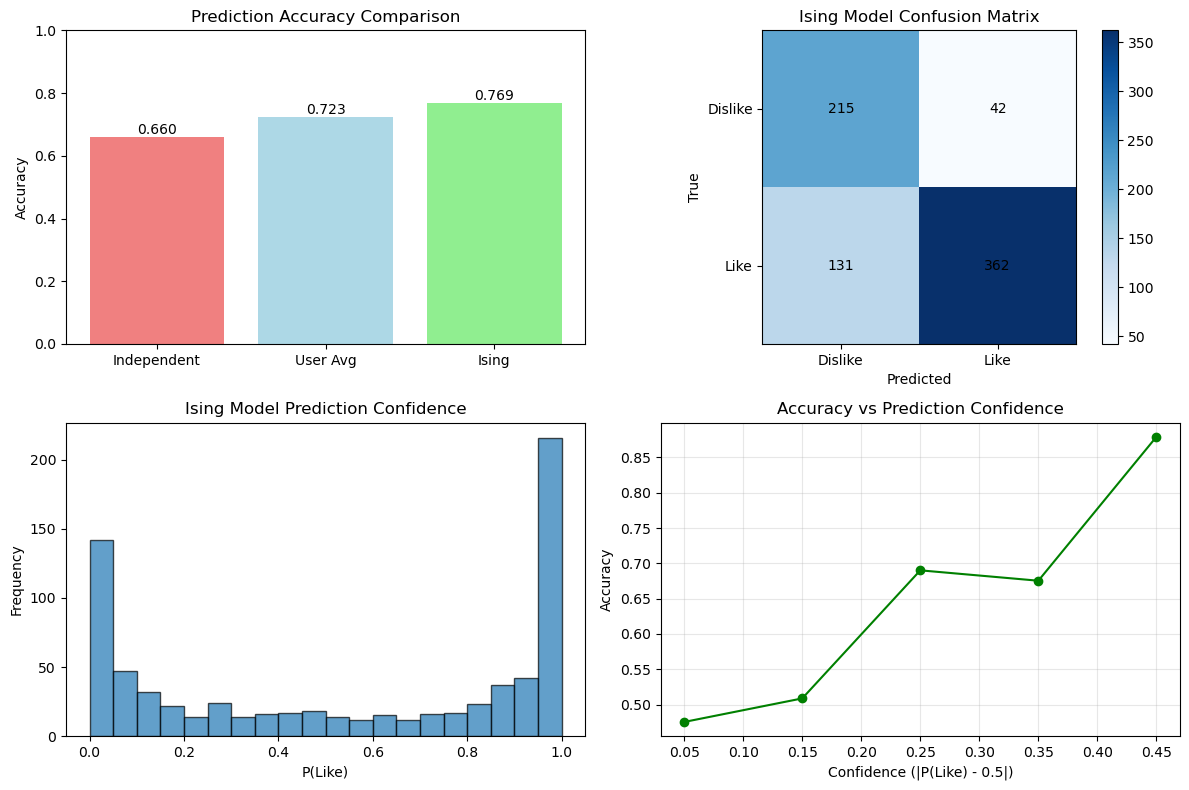


EVALUATION SUMMARY
Best performing method: Ising Model
Accuracy improvement: 0.1093
Ising model accuracy: 0.7693
Relative improvement: 16.6%


In [26]:
## STEP 5: ANALYZE PREDICTION PATTERNS

print(f"\n" + "="*50)
print("PREDICTION ANALYSIS")
print("="*50)

# Which movies are hardest to predict?
movie_errors = {}
for i, (user_idx, movie_idx) in enumerate(test_positions):
    if pred_ising[i] != y_true[i]:
        if movie_idx not in movie_errors:
            movie_errors[movie_idx] = 0
        movie_errors[movie_idx] += 1

if movie_errors:
    print(f"Movies with most prediction errors:")
    sorted_errors = sorted(movie_errors.items(), key=lambda x: x[1], reverse=True)
    for movie_idx, error_count in sorted_errors[:5]:
        total_predictions = sum(1 for _, mid in test_positions if mid == movie_idx)
        error_rate = error_count / total_predictions if total_predictions > 0 else 0
        print(f"  {movie_titles[movie_idx]:25s}: {error_count}/{total_predictions} = {error_rate:.3f}")

# Visualize prediction comparison
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
methods_short = ['Independent', 'User Avg', 'Ising']
plt.bar(methods_short, accuracies, color=['lightcoral', 'lightblue', 'lightgreen'])
plt.title('Prediction Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.3f}', ha='center')

plt.subplot(2, 2, 2)
# Confusion matrix for Ising model
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, pred_ising)
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Ising Model Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks([0, 1], ['Dislike', 'Like'])
plt.yticks([0, 1], ['Dislike', 'Like'])

# Add text annotations
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center')

plt.subplot(2, 2, 3)
# Prediction confidence analysis
ising_probs = []
for user_idx, movie_idx in test_positions:
    user_ratings = X_train[user_idx]
    linear_term = best_th_i[movie_idx]
    neighbor_indices = best_nbrs[movie_idx]
    for k, neighbor_idx in enumerate(neighbor_indices):
        if user_ratings[neighbor_idx] != -1:
            linear_term += best_th_ij[movie_idx][k] * user_ratings[neighbor_idx]
    prob = 1 / (1 + np.exp(-2 * linear_term))
    ising_probs.append(prob)

ising_probs = np.array(ising_probs)
plt.hist(ising_probs, bins=20, alpha=0.7, edgecolor='black')
plt.title('Ising Model Prediction Confidence')
plt.xlabel('P(Like)')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
# Accuracy vs confidence
confidence = np.abs(ising_probs - 0.5)  # Distance from 0.5
correct = (pred_ising == y_true)

bins = np.linspace(0, 0.5, 6)
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_accuracies = []

for i in range(len(bins)-1):
    mask = (confidence >= bins[i]) & (confidence < bins[i+1])
    if mask.sum() > 0:
        bin_accuracies.append(correct[mask].mean())
    else:
        bin_accuracies.append(0)

plt.plot(bin_centers, bin_accuracies, 'o-', color='green')
plt.title('Accuracy vs Prediction Confidence')
plt.xlabel('Confidence (|P(Like) - 0.5|)')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n" + "="*60)
print("EVALUATION SUMMARY")
print("="*60)
print(f"Best performing method: {methods[np.argmax(accuracies)]}")
print(f"Accuracy improvement: {max(accuracies) - min(accuracies):.4f}")
print(f"Ising model accuracy: {acc_ising:.4f}")
print(f"Relative improvement: {(acc_ising - acc_independent)/acc_independent*100:.1f}%")